# Google Top Stories - An exploration

**Description:** This dataset was collected during the pandemic, it contains headlines shown by Google Search.
It is organized by year, month, date, hour, in a series of nested folders. The leaf folders contain JSON files with information about Google's top stories. 

Your goal is to write first a Python function that takes the name of the folder "GoogleTopStories" and stores the content of all the JSON files into a single CSV file. Once you have a CSV file, you can practice your pandas & seaborn skills in analyzing the data.

Some tips and ideas for analysis:
1. Use the Python command `os.walk` to iteratively traverse the nested subfolders. Account for hidden files that start with .
2. Although the dataset has a column domain, imagine that it doesn't have it and write a function that takes a URL and extracts the domain name from it and saves it in a column. Use the `.apply` method to create the column. Learn how to parse URLs with `urllib.parse`.
3. Create a bar chart with the frequencies of the top 10 domains. (Use domains, since 'source name' contains duplicates.)
4. Create a heatmap that shows the distribution of domains across the 'story_position' values.
5. Create timeseries of unique articles per month by query type. (This is challenging, because it is not using pandas' timeseries.)


**Table of Content [Solutions]**
1. [Reading all JSON files](#sec1)
2. [Creating a new column](#sec2)
3. [Bar chart of top domains](#sec3)
4. [Heatmap for the story positions](#sec4)
5. [Timeseries of unique articles by query](#sec5)

<a id="sec1"></a>
## Part 1: Reading all JSON files

Spend some time looking at the structure of the folders and subfolders in GoogleTopStories. You should notice the deep nesting. The function `os.walk` recursively traverses this nested structure. 

In [2]:
import os, json, csv

def writeFilesToCSV(pathName):
    """
    Takes a foldername as an argument. Recursively reads all JSON files 
    and saves their content into a list. At the end, saves all data into a CSV file.
    """
    allTopStories = []
    totalFiles = 0
    for dirpath, dirnames, filenames in os.walk(pathName):
        for fN in filenames: 
            if fN.endswith('.json'): # Avoid any other types of files, such as .DS_Store
                totalFiles += 1
                filePath = os.path.join(dirpath, fN) # create the whole path of a file
                with open(filePath) as inputF:
                    data = json.load(inputF)
                    allTopStories.extend(data)
                
    print("Total number of JSON files:", totalFiles)
    print("Total number of Top stories in the files:", len(allTopStories))

    with open("our-results.csv", "w") as fout:
        header = list(allTopStories[0].keys()) + ['category'] # Notice this, because not all top stories have a "category"
        dW = csv.DictWriter(fout, fieldnames=header)
        dW.writeheader()
        dW.writerows(allTopStories)

In [3]:
# Call the function for our folder
writeFilesToCSV('GoogleTopStories')

Total number of JSON files: 2442
Total number of Top stories in the files: 16945


**Your task: Explore how `os.walk` works**

In order to see how os.walks works, use below the for loop from the function to only explore the month of Aprill 2020, by printing out what the for loop generates.

In [4]:
allTopStories = []
totalFiles = 0
for dirpath, dirnames, filenames in os.walk("GoogleTopStories/2020/04"):
        for fN in filenames: 
            if fN.endswith('.json'): # Avoid any other types of files, such as .DS_Store
                totalFiles += 1
                filePath = os.path.join(dirpath, fN) # create the whole path of a file
                with open(filePath) as inputF:
                    data = json.load(inputF)
                    allTopStories.extend(data)
print("Total number of JSON files:", totalFiles)
print("Total number of Top stories in the files:", len(allTopStories))

Total number of JSON files: 44
Total number of Top stories in the files: 349


<a id="sec2"></a>
## Part 2: Create the new `domain` column

Let's load the data that we created in Part 1 into a dataframe.

In [5]:
import pandas as pd

df = pd.read_csv('our-results.csv')
df.head()

/var/folders/cw/4tmbrj3d1pzd4rhyrm8vnwyc0000gn/T/ipykernel_49470/2414338559.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,title,url,source,time,date,query,story_position,domain,category
0,Live Covid-19 News Updates: The Latest,https://www.nytimes.com/live/2021/02/03/world/...,The New York Times,2 hours ago,2021-02-03 22:00:00,Covid-19,1,www.nytimes.com,NaN
1,The latest on the coronavirus pandemic and vac...,https://www.cnn.com/world/live-news/coronaviru...,CNN,50 mins ago,2021-02-03 22:00:00,Covid-19,2,www.cnn.com,NaN
2,Chiefs' Daniel Kilgore releases photo of unfin...,https://www.foxnews.com/sports/chiefs-daniel-k...,Fox News,48 mins ago,2021-02-03 22:00:00,Covid-19,3,www.foxnews.com,NaN
3,Younger adults are biggest spreaders of Covid-...,https://www.cnn.com/2021/02/03/health/younger-...,CNN,35 mins ago,2021-02-03 22:00:00,Covid-19,4,www.cnn.com,NaN
4,Idaho’s daily average of new COVID-19 cases re...,https://www.idahostatesman.com/news/coronaviru...,Idaho Statesman,51 mins ago,2021-02-03 22:00:00,Covid-19,5,www.idahostatesman.com,NaN


**How to extract the domain name from the URL?**

In [6]:
from urllib.parse import urlparse

oneUrl = df.iloc[0]['url'] # retrieve url from first row of dataframe
urlparse(oneUrl)

ParseResult(scheme='https', netloc='www.nytimes.com', path='/live/2021/02/03/world/covid-19-coronavirus', params='', query='', fragment='')

Notice that the result is an object and the domain name is the value of the attribute `netloc`. Now, we can easily make use of this to write the helper function to extract the domain name.

**Write a helper function**

In [7]:
from urllib.parse import urlparse

def getDomain(field):
    """returns the domain name of a url"""
    return urlparse(field).netloc


Apply the helper function to the whole column and store the results to a new column:

In [8]:
df['domain2'] = df['url'].apply(getDomain)
df.head()

,title,url,source,time,date,query,story_position,domain,category,domain2
0,Live Covid-19 News Updates: The Latest,https://www.nytimes.com/live/2021/02/03/world/...,The New York Times,2 hours ago,2021-02-03 22:00:00,Covid-19,1,www.nytimes.com,NaN,www.nytimes.com
1,The latest on the coronavirus pandemic and vac...,https://www.cnn.com/world/live-news/coronaviru...,CNN,50 mins ago,2021-02-03 22:00:00,Covid-19,2,www.cnn.com,NaN,www.cnn.com
2,Chiefs' Daniel Kilgore releases photo of unfin...,https://www.foxnews.com/sports/chiefs-daniel-k...,Fox News,48 mins ago,2021-02-03 22:00:00,Covid-19,3,www.foxnews.com,NaN,www.foxnews.com
3,Younger adults are biggest spreaders of Covid-...,https://www.cnn.com/2021/02/03/health/younger-...,CNN,35 mins ago,2021-02-03 22:00:00,Covid-19,4,www.cnn.com,NaN,www.cnn.com
4,Idaho’s daily average of new COVID-19 cases re...,https://www.idahostatesman.com/news/coronaviru...,Idaho Statesman,51 mins ago,2021-02-03 22:00:00,Covid-19,5,www.idahostatesman.com,NaN,www.idahostatesman.com


**Your Task: Create a new column**

Create a new column that will store the number of words on the title of each article. The column name should be `wordCount`. Show the head of the dataframe to indicate that the column was created.

In [9]:
df["wordCount"] = [len(title.split(" ")) for title in df.title]
df.head(5)

,title,url,source,time,date,query,story_position,domain,category,domain2,wordCount
0,Live Covid-19 News Updates: The Latest,https://www.nytimes.com/live/2021/02/03/world/...,The New York Times,2 hours ago,2021-02-03 22:00:00,Covid-19,1,www.nytimes.com,NaN,www.nytimes.com,6
1,The latest on the coronavirus pandemic and vac...,https://www.cnn.com/world/live-news/coronaviru...,CNN,50 mins ago,2021-02-03 22:00:00,Covid-19,2,www.cnn.com,NaN,www.cnn.com,10
2,Chiefs' Daniel Kilgore releases photo of unfin...,https://www.foxnews.com/sports/chiefs-daniel-k...,Fox News,48 mins ago,2021-02-03 22:00:00,Covid-19,3,www.foxnews.com,NaN,www.foxnews.com,15
3,Younger adults are biggest spreaders of Covid-...,https://www.cnn.com/2021/02/03/health/younger-...,CNN,35 mins ago,2021-02-03 22:00:00,Covid-19,4,www.cnn.com,NaN,www.cnn.com,9
4,Idaho’s daily average of new COVID-19 cases re...,https://www.idahostatesman.com/news/coronaviru...,Idaho Statesman,51 mins ago,2021-02-03 22:00:00,Covid-19,5,www.idahostatesman.com,NaN,www.idahostatesman.com,13


<a id="sec3"></a>
## Part 3: Bar chart of top 10 domains

To create the bar chart of the top 10 domains, we first need to find the top 10 domains.

The method `value_counts` returns a **sorted** series of counts for each value in a column.

In [10]:
# Find the top 10 domains using value_counts
domainCounts = df['domain'].value_counts()[:10]

Let's see what it looks like:

In [11]:
domainCounts

domain
www.cnn.com               1834
www.nytimes.com           1246
www.washingtonpost.com     826
www.foxnews.com            801
www.cnbc.com               577
www.npr.org                543
www.usatoday.com           492
www.nbcnews.com            492
thehill.com                477
nypost.com                 459
Name: count, dtype: int64

Let's look up the type of our our result:

In [12]:
type(domainCounts)

pandas.core.series.Series

Since the result is a Series, we will convert it to a dataframe. [**Note:** The method `reset_index` converts a Series into a DataFrame, where the original index becomes a column in the DataFrame, and the Series values occupies another column, for which we have to provide a column name.]

In [13]:
data = domainCounts.reset_index(name='count')
data

,domain,count
0,www.cnn.com,1834
1,www.nytimes.com,1246
2,www.washingtonpost.com,826
3,www.foxnews.com,801
4,www.cnbc.com,577
5,www.npr.org,543
6,www.usatoday.com,492
7,www.nbcnews.com,492
8,thehill.com,477
9,nypost.com,459


Now that we have a dataframe we can use Seaborn to generate charts. Below I'm creating a bar plot.

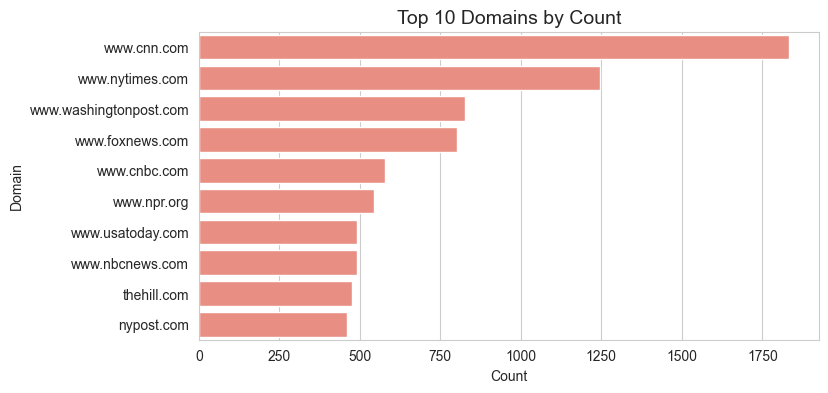

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))   # adjusting the size of the figure where the plot will be displayed
sns.set_style("whitegrid")  

# Create the horizontal bar plot
ax = sns.barplot(x='count', y='domain', data=data, color="salmon", legend=None)

# Set titles
ax.set_xlabel("Count", fontsize=10)
ax.set_ylabel("Domain", fontsize=10)
ax.set_title("Top 10 Domains by Count", fontsize=14)

# Display the plot
plt.show()

**Your Task: Create a bar chart of query occurrences**

Adapt the code above to generate the bar chart of the query occurrences. Make sure that you change the barplot titles to reflect the new variable being displayed. Change the color of the graph and [visit this Seaborn documentation page](https://seaborn.pydata.org/tutorial/aesthetics.html) for inspiration on changing the style of the plot.

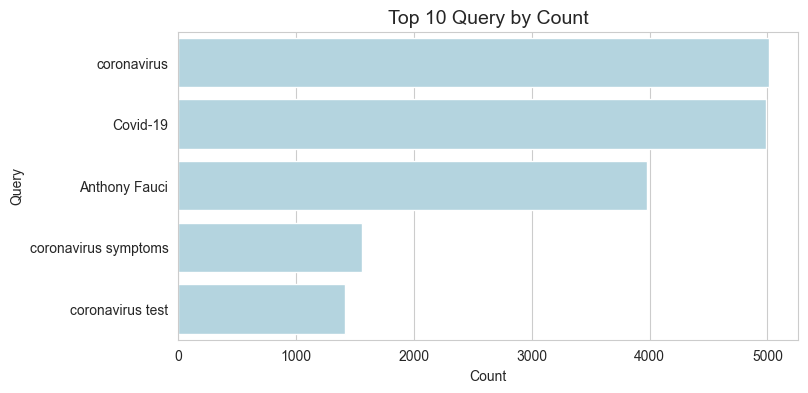

In [29]:
query_data = df['query'].value_counts().reset_index(name='count')

plt.figure(figsize=(8, 4))   # adjusting the size of the figure where the plot will be displayed
sns.set_style("whitegrid")  
ax = sns.barplot(x='count', y='query', data=query_data, color="lightblue", legend=None)
ax.set_xlabel("Count", fontsize=10)
ax.set_ylabel("Query", fontsize=10)
ax.set_title("Top 10 Query by Count", fontsize=14)
plt.show()

<a id="sec4"></a>
## Part 4: Heatmap for the story positions

We are interested in the question: Are all news sources equally likely to show up in all positions? Or some of them show up more frequently in a certain position? To explore this question visually, we will create a heatmap. However, since there are hundreds of news sources in our dataset, we will focus only on the top 10 for simplicity.

In [16]:
# First, find the names of the top 10 domains
# Then, filter the dataframe to select only the rows of one of the top 10 domains (articles that belong to these news domains)

topTen = df['domain'].value_counts()[:10].index.tolist() # remember from part 3 that value_counts returns a Series and the 'domain' column is the index of it
dfSmall = df[df['domain'].isin(topTen)] # do the filtering. Notice the filter syntax.
dfSmall.shape

(7747, 11)

As a reminder, here is what the size of the whole dataframe is:

In [ ]:
df.shape

Let's calcuate the proportion of articles from the top 10 domains:

In [17]:
proportion = dfSmall.shape[0]/df.shape[0] * 100
proportion

45.718501032753025

**Question:** What does the fact that the proportion of the occurrences of the top 10 domains comes at 45% tell us about Google's algorithms?

**Your Answer:** Google seems to push the same top 10 domains when returning information about a particular topic - perhaps, this has to do with if people tend to click on these domains more often.

### Creating a pivot table

Our current dataframe, `dfSmall` presents itself as a **tidy table**, each row is an observation. We will now convert it to a form that it is not a **tidy table**, because the columns will become values of the variable "story_position". This will allow us to count how many domains show up in each of the 10 positions.

To create such a table we will use pandas' `pivot_table` method, which builds upon the `groupby` method that we have seen.

In [18]:
# First, let's create the pivot table to count each domain occurrence by position

dfFinal = dfSmall[['domain', 'story_position']] # work with a two-column dataframe

pivotDF = dfFinal.pivot_table(index='domain', columns='story_position', 
                              aggfunc='size',fill_value=0)
pivotDF.head(10)

story_position,1,2,3,4,5,6,7,8,9,10
domain,,,,,,,,,,
nypost.com,64,65,75,37,33,37,41,39,36,32
thehill.com,32,43,82,70,62,28,39,55,37,29
www.cnbc.com,103,77,57,50,49,53,39,38,51,60
www.cnn.com,479,480,190,98,82,138,122,100,80,65
www.foxnews.com,99,101,137,79,74,87,56,60,55,53
www.nbcnews.com,30,63,51,36,41,38,64,58,51,60
www.npr.org,86,107,42,21,22,41,48,55,65,56
www.nytimes.com,634,274,75,22,29,42,47,51,38,34
www.usatoday.com,47,61,74,33,31,48,49,49,52,48


Now that we have a dataframe, let's normalize the rows by dividing each cell in a column by the sum of values of that row:

In [19]:
normalized = pivotDF.div(pivotDF.sum(axis=1), # first generate the sum of values in each row
                         axis=0) # then divide all cells in a colum, by the corresponding sum
normalized

story_position,1,2,3,4,5,6,7,8,9,10
domain,,,,,,,,,,
nypost.com,0.139434,0.141612,0.163399,0.080610,0.071895,0.080610,0.089325,0.084967,0.078431,0.069717
thehill.com,0.067086,0.090147,0.171908,0.146751,0.129979,0.058700,0.081761,0.115304,0.077568,0.060797
www.cnbc.com,0.178510,0.133449,0.098787,0.086655,0.084922,0.091854,0.067591,0.065858,0.088388,0.103986
www.cnn.com,0.261178,0.261723,0.103599,0.053435,0.044711,0.075245,0.066521,0.054526,0.043621,0.035442
www.foxnews.com,0.123596,0.126092,0.171036,0.098627,0.092385,0.108614,0.069913,0.074906,0.068664,0.066167
www.nbcnews.com,0.060976,0.128049,0.103659,0.073171,0.083333,0.077236,0.130081,0.117886,0.103659,0.121951
www.npr.org,0.158379,0.197053,0.077348,0.038674,0.040516,0.075506,0.088398,0.101289,0.119705,0.103131
www.nytimes.com,0.508828,0.219904,0.060193,0.017657,0.023274,0.033708,0.037721,0.040931,0.030498,0.027287
www.usatoday.com,0.095528,0.123984,0.150407,0.067073,0.063008,0.097561,0.099593,0.099593,0.105691,0.097561


Now that the data is ready, we can create the heatmap, providing some additional instructions to make it look good:

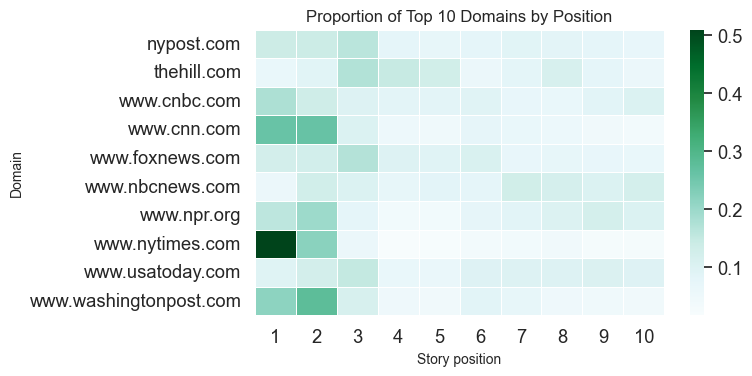

In [20]:
# Create a heatmap
plt.figure(figsize=(8, 4))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(normalized, 
            cmap='BuGn', # set color map Blue to Green
            annot=False, # do not show the numerical values in each cell
            linewidths=0.5) # width of lines that separate the cells in the map

# We are directly setting the properties of the current axes, without explicitely referring to it as we did in the barplot image
plt.xlabel('Story position', fontsize=10)
plt.ylabel('Domain', fontsize=10)
plt.title('Proportion of Top 10 Domains by Position', fontsize=12)

plt.tight_layout()
plt.show()

**Questions:** Given this visualization, how can we answer our starting question: Are all news sources equally likely to show up in all positions?  
Furthermore, what does this tell us about Google's algorithms?

**Your Answer:** It seems like not all news sources are equally likely to show up in all positions since cnn, nytimes, washingtonpost, cnbc, and npr tend to be recommended more in the top stories than other news domains. It may suggest that Google favors these domains more than other news domains.

<a id="sec5"></a>
## 5. Timeseries of monthly unique articles organized by query type

From prior experience in working with Google Top Stories data, I know that some articles show up multiple times during the day or over a few days. We can verify this through code:

In [21]:
df.url.unique().size == df.url.size # compare sizes

False

Print the sizes to compare unique url to the total urls:

In [22]:
print(f"Unique: {df.url.unique().size}, Total: {df.url.size}")

Unique: 12265, Total: 16945


**Your Task: Domains and Sources**  
Throughout the notebook, we worked with the domain column, instead of source. 
1. Check if these two columns have the same size in terms of unique values.
2. What is the size of unique values for each of them?
3. Speculate about the reason for the divergence between the two columns.

**Your exploration**

In [33]:
# task 1 & 2
if df.source.unique().size == df.domain.unique().size:
    print("Task 1 & 2: Domain and Source columns have the same size in terms of unique values.\n",
          "Size of source column:",df.source.unique().size, "\n",
          "Size of domain column:",df.domain.unique().size, "\n",)
else:
    print("Task 1 & 2: Domain and Source columns do not have the same size in terms of unique values.\n",
          "Size of source column:",df.source.unique().size, "\n",
          "Size of domain column:",df.domain.unique().size, "\n",)

print(df.source)
print(df.domain)

Task 1 & 2: Domain and Source columns do not have the same size in terms of unique values.
 Size of source column: 1048 
 Size of domain column: 811 

0        The New York Times
1                       CNN
2                  Fox News
3                       CNN
4           Idaho Statesman
                ...        
16940                   NPR
16941       Washington Post
16942                   NPR
16943                   NPR
16944             The Verge
Name: source, Length: 16945, dtype: object
0               www.nytimes.com
1                   www.cnn.com
2               www.foxnews.com
3                   www.cnn.com
4        www.idahostatesman.com
                  ...          
16940               www.npr.org
16941    www.washingtonpost.com
16942               www.npr.org
16943               www.npr.org
16944          www.theverge.com
Name: domain, Length: 16945, dtype: object


Task 3: Source names seem to be the name of the website but domain is generally with more information (with www. and .com or .org). Therefore, perhaps there are sites where they have multiple domains that slightly differ (for example, perhaps there is a source name for "The New York Times" but also "The New York Times | Breaking News" while sharing the same www.nytimes.com domain). In that case, we would expect there to be more source names than domain names.

### Focus on unique articles

Let's start by dropping all the rows that have repeating URLs, however, we will first sort the rows, so that they are in the order of publication.

In [34]:
df.sort_values(by=['date'], inplace=True)
df.head()

,title,url,source,time,date,query,story_position,domain,category,domain2,wordCount
2522,Trump’s COVID-19 failure shows his ‘omnipotent...,https://www.rawstory.com/2020/04/trumps-covid-...,Raw Story,3 hours ago,2020-04-25 22:00:00,Covid-19,6,www.rawstory.com,NaN,www.rawstory.com,18
2542,Detroit Health Care Worker Dies After Being De...,https://www.nbcphiladelphia.com/news/national-...,NBC10 Philadelphia,47 mins ago,2020-04-25 22:00:00,coronavirus test,3,www.nbcphiladelphia.com,NaN,www.nbcphiladelphia.com,14
2517,"Coronavirus daily news updates, April 25: What...",https://www.seattletimes.com/seattle-news/heal...,The Seattle Times,10 hours ago,2020-04-25 22:00:00,Covid-19,1,www.seattletimes.com,NaN,www.seattletimes.com,21
2518,The one ritual keeping me sane during Covid-19,https://www.cnn.com/2020/04/25/opinions/covid-...,CNN.com,13 hours ago,2020-04-25 22:00:00,Covid-19,2,www.cnn.com,NaN,www.cnn.com,8
2519,Dyson Built a New Ventilator to Treat Covid-19...,https://gizmodo.com/dyson-built-a-new-ventilat...,Gizmodo,44 mins ago,2020-04-25 22:00:00,Covid-19,3,gizmodo.com,NaN,gizmodo.com,18


We can see from the indices (they don't start at 0 any longer) that the rows were sorted. Let's drop the duplicate URLs:

In [35]:
dfUnique = df.drop_duplicates(subset=['url']) 
dfUnique.shape

(12265, 11)

I will create a new column, year-month, since the date field is too granular. [**Note**: Read more about this at the end of the notebook.]

In [36]:
def splitDate(row):
    """return a date in the format YYYY-MM"""
    return row['date'][:7] 

dfUnique['year-month'] = dfUnique.apply(splitDate, axis=1)
dfUnique.head()

/var/folders/cw/4tmbrj3d1pzd4rhyrm8vnwyc0000gn/T/ipykernel_49470/1694280622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique['year-month'] = dfUnique.apply(splitDate, axis=1)


,title,url,source,time,date,query,story_position,domain,category,domain2,wordCount,year-month
2522,Trump’s COVID-19 failure shows his ‘omnipotent...,https://www.rawstory.com/2020/04/trumps-covid-...,Raw Story,3 hours ago,2020-04-25 22:00:00,Covid-19,6,www.rawstory.com,NaN,www.rawstory.com,18,2020-04
2542,Detroit Health Care Worker Dies After Being De...,https://www.nbcphiladelphia.com/news/national-...,NBC10 Philadelphia,47 mins ago,2020-04-25 22:00:00,coronavirus test,3,www.nbcphiladelphia.com,NaN,www.nbcphiladelphia.com,14,2020-04
2517,"Coronavirus daily news updates, April 25: What...",https://www.seattletimes.com/seattle-news/heal...,The Seattle Times,10 hours ago,2020-04-25 22:00:00,Covid-19,1,www.seattletimes.com,NaN,www.seattletimes.com,21,2020-04
2518,The one ritual keeping me sane during Covid-19,https://www.cnn.com/2020/04/25/opinions/covid-...,CNN.com,13 hours ago,2020-04-25 22:00:00,Covid-19,2,www.cnn.com,NaN,www.cnn.com,8,2020-04
2519,Dyson Built a New Ventilator to Treat Covid-19...,https://gizmodo.com/dyson-built-a-new-ventilat...,Gizmodo,44 mins ago,2020-04-25 22:00:00,Covid-19,3,gizmodo.com,NaN,gizmodo.com,18,2020-04


**Important Note:** When running the cell above, some of you might have received the following warning:  
A value is trying to be set on a copy of a slice from a DataFrame.

When we run the statement `dfUnique = df.drop_duplicates(subset=['url'])` we intended to create a new dataframe. However, pandas warns us because it can't guarantee that dfUnique isn't sharing data with df under the hood due to its optimizations. The longer explanation is that pandas sometimes uses views internally to optimize memory usage. When we perform an operation that could be ambiguous, such as modifying a DataFrame that could potentially be a view of another DataFrame, pandas issues a warning.

If we don't want the warning to show, we should explicitely tell pandas make a new copy:

`dfUnique = df.drop_duplicates(subset=['url']).copy()`

### Pivot Table: counting articles per query

Now that each row has a month value, we can create a pivot table to count how many time a query showed in each month.

In [37]:
queryMonthDF = dfUnique.pivot_table(index="query", 
                                    columns="year-month", 
                                    aggfunc="size", 
                                    fill_value=0)
queryMonthDF.head()

year-month,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02
query,,,,,,,,,,,
Anthony Fauci,0,175,304,321,156,220,274,228,204,217,58
Covid-19,102,531,526,472,342,416,485,457,401,434,125
coronavirus,95,512,492,449,327,399,439,420,382,378,107
coronavirus symptoms,55,98,98,97,76,84,98,77,80,95,25
coronavirus test,42,137,86,55,73,111,126,105,87,91,21


Let's validate that all articles are shown in this table:

In [38]:
queryMonthDF.sum().sum()

12265

It's looks right!

### Generate the time series plot

There are many ways to create a time series plot. Because I gave you this task before you had seen pandas timeseries, below I will show how to create the plot using linebars. There are two ways to do this.

**Soution 1: Plot line bars with a for loop**

Because the table we created above is a pivot table, also known as a "wide table" (different from the "tidy table"), seaborn doesn't know how to work with it directly, so we have to generate each line within a for loop. 

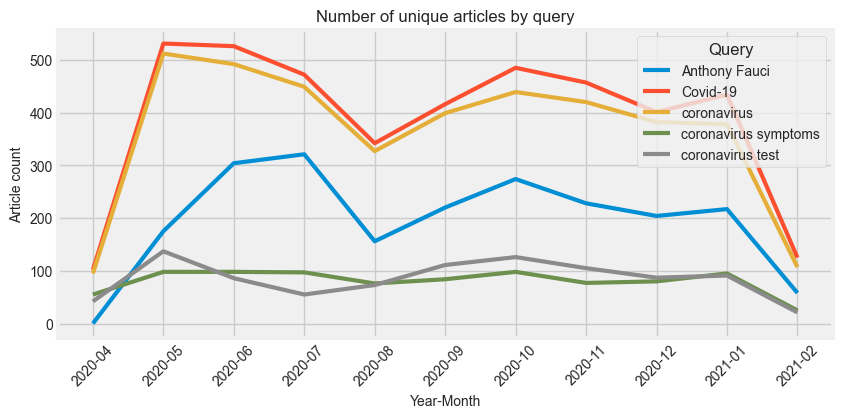

In [39]:
plt.figure(figsize=(10, 4))
plt.style.use('fivethirtyeight')

# Iterate over each row to plot
for index, row in queryMonthDF.iterrows():
    sns.lineplot(x=queryMonthDF.columns,  # the year-month values
                 y=row.values,  # the counts for each query
                 label=index, # this will be the query values
                 lw=3)

# Change the parameters of the current axes (plot) to deal with the font size
plt.xticks(rotation=45) # Rotate dates
plt.ylabel('Article count', fontsize=10)
plt.xlabel('Year-Month', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Number of unique articles by query', fontsize=12)
plt.legend(title='Query', fontsize=10, loc="upper right", title_fontsize=12)

plt.show()

**Solution 2: Wide table vs. long table**

We mentioned that the `pivot_table` method creates a **wide format table**. Seaborn prefers to work with a **long format table** (we called it the tidy data).  
Thus, we will convert the wide table to a long table.

First, let's look again at our wide-format table:

In [40]:
queryMonthDF

year-month,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02
query,,,,,,,,,,,
Anthony Fauci,0,175,304,321,156,220,274,228,204,217,58
Covid-19,102,531,526,472,342,416,485,457,401,434,125
coronavirus,95,512,492,449,327,399,439,420,382,378,107
coronavirus symptoms,55,98,98,97,76,84,98,77,80,95,25
coronavirus test,42,137,86,55,73,111,126,105,87,91,21


Notice that the first column, query, is also serving as an index column. Eventually, what we want is to **unpivot** this table and create a table that looks like this:

```
query year-month count
Anthony Fauci 2020-04 0
Anthony Fauci 2020-05 175
Anthony Fauci 2020-06 304
...
Covid-19 2020-04 102
Covid-19 2020-04 531
...
```

That is from a table that now has 11 colums x 5 rows, we want a table with 3 columns and 55 rows (from wide to long).

The method `melt` below will perform this:

In [41]:
dfLongTab = queryMonthDF.reset_index().melt(id_vars='query',  # column that remains an "identifier" column, will not be melted
                                          var_name='year-month', # name for variable column created after the melting (this contains names of melted columns)
                                          value_name='count') # column created after melting (contains values of melted columns)
dfLongTab.head()

,query,year-month,count
0,Anthony Fauci,2020-04,0
1,Covid-19,2020-04,102
2,coronavirus,2020-04,95
3,coronavirus symptoms,2020-04,55
4,coronavirus test,2020-04,42


Let's check the shape of the created dataframe. 

In [42]:
dfLongTab.shape

(55, 3)

It's exactly what we expected!

Now that we have the data in the desired format, we can do the plotting without having to use a for loop to iterate through the lines, seaborn will do that itself.

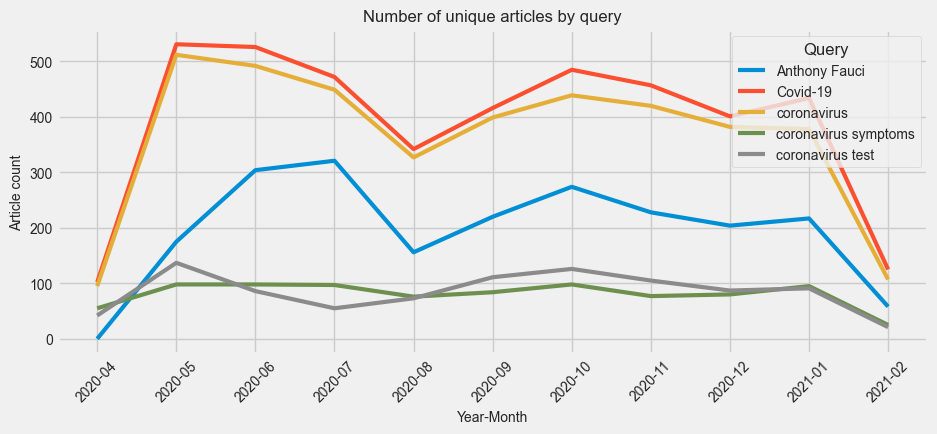

In [43]:
plt.figure(figsize=(10, 4))
plt.style.use('fivethirtyeight')

sns.lineplot(data=dfLongTab, 
             x='year-month', 
             y='count', 
             hue='query', lw=3)

# Change the parameters of the current axes (plot) to deal with the font size
plt.xticks(rotation=45) # Rotate dates
plt.ylabel('Article count', fontsize=10)
plt.xlabel('Year-Month', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Number of unique articles by query', fontsize=12)
plt.legend(title='Query', fontsize=10, loc="upper right", title_fontsize=12)

plt.show()

Notice that we produced the same graph but with two different starting dataframes and code for generating the lines. 

**Your Task: Plot each month**

Using the code above, create two functions:
1. Create a function that given a year-month value, for example: "2020-05", prepares the dataframe that contains the "month-day" counts of the unique articles for each query.
2. Create a function that can take the output from point 1) and plot the lineplot.

Excecute these functions for at least two dates.

/var/folders/cw/4tmbrj3d1pzd4rhyrm8vnwyc0000gn/T/ipykernel_49470/1374517106.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUnique['year-month-date'] = dfUnique.apply(splitDate2, axis=1)
/var/folders/cw/4tmbrj3d1pzd4rhyrm8vnwyc0000gn/T/ipykernel_49470/1374517106.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df["month-date"] = current_df.apply(splitDate4, axis=1)


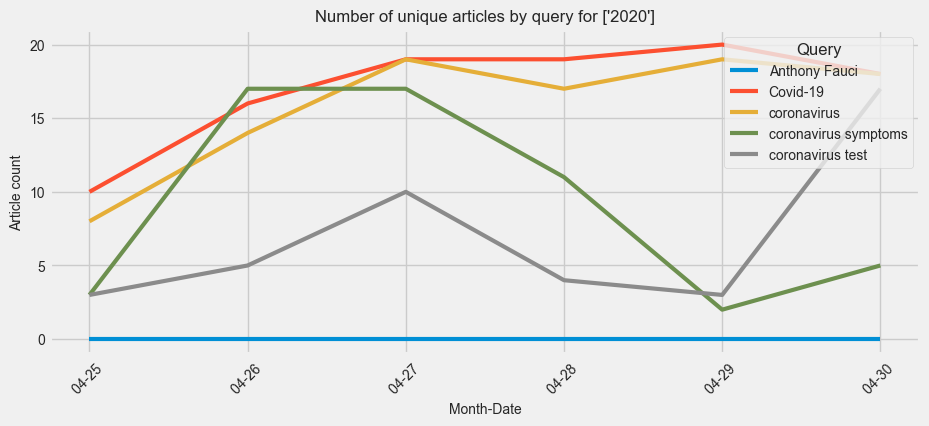

In [92]:
# task 1
def splitDate2(row):
    return row['date'][:11] 

def splitDate3(row):
    return row['year-month-date'][:7]

def splitDate4(row):
    return row['year-month-date'][5:]

def create_df_md(year_month):
    dfUnique['year-month-date'] = dfUnique.apply(splitDate2, axis=1)
    queryMonthDF = dfUnique.pivot_table(index="query", columns="year-month-date", aggfunc="size", fill_value=0)
    dfLongTab = queryMonthDF.reset_index().melt(id_vars='query', var_name='year-month-date', value_name='count') 
    
    dfLongTab["year-month"] = dfLongTab.apply(splitDate3, axis=1)
    current_df = dfLongTab[dfLongTab["year-month"] == year_month]
    current_df["month-date"] = current_df.apply(splitDate4, axis=1)
    return pd.DataFrame({"query": current_df["query"], "date": current_df["month-date"],  "count": current_df["count"], "year": year_month[:4]})

#task 2
def plot_df(df):
    plt.figure(figsize=(10, 4))
    plt.style.use('fivethirtyeight')
    sns.lineplot(data=df, x='date', y='count', hue='query', lw=3)
    plt.xticks(rotation=45) # Rotate dates
    plt.ylabel('Article count', fontsize=10); plt.xlabel('Month-Date', fontsize=10)
    plt.xticks(fontsize=10); plt.yticks(fontsize=10)
    plt.title('Number of unique articles by query for {}'.format(df["year"].unique()), fontsize=12)
    plt.legend(title='Query', fontsize=10, loc="upper right", title_fontsize=12)
    plt.show()

plot_df(create_df_md("2020-04"))